hemoglobin
10 mg/mL
simulate 1 shot
no noise

In [22]:
import numpy as np
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.pyplot as plt
import sys
sys.path.append('/sdf/scratch/lcls/ds/cxi/cxily5921/scratch/aansari2/cxily59/reborn')
import reborn
from reborn.detector import load_pad_geometry_list
from reborn.external import denss
from reborn.source import load_beam

In [23]:
name = "ly59_hgb_saxs_sim"
n_frames = 10000
concentration = 10 # mg/mL
sheet_thickness = 30e-9
nq_bins = 500

In [24]:
print("Setting up beam.")
beam = load_beam('../../../../geometry/beam.json') # beam
beam.diameter_fwhm = 120e-9

Setting up beam.


In [25]:
print("Setting up detector geometry.")
geom = load_pad_geometry_list('../../../../geometry/current.json') #geometry

#geom = reborn.detector.load_pad_geometry_list("./geometry/ly59_geometry.json")
# # remove: (edge + dead + hot) pixels
# mask = reborn.detector.load_pad_masks([
#     "./geometry/ly59_edge.mask",
#     "./geometry/ly59_dead.mask",
#     "./geometry/ly59_hot.mask"]
# )
# mask = geom.concat_data(mask) # ravel data consistently
# mask = mask.astype(bool) # convert int64 to boolean

Setting up detector geometry.


In [26]:
pad_qs = geom.q_mags(beam=beam)
pad_f2p = geom.f2phot(beam=beam)

In [27]:
# precompute radial bin
max_q = 6e9
qbins = np.linspace(0, max_q, nq_bins + 1) # nodal points of radial bins
binindex = np.digitize(pad_qs, qbins[:-1]) - 1  # Adjust to include the rightmost edge
f2p = np.zeros(nq_bins) 
np.add.at(f2p, binindex, pad_f2p)

In [28]:
weights = np.zeros(nq_bins)
np.add.at(weights, binindex, geom.ones())

In [29]:
print("Setting up molecule.")
molecule = reborn.target.crystal.CrystalStructure(
    "./2qsp.pdb",
    create_bio_assembly=True,
).molecule
sheet_V = np.pi * sheet_thickness * (beam.diameter_fwhm / 2) ** 2
print(f"Beam diameter: {beam.diameter_fwhm:.2e}")
print(f"Sheet thickness: {sheet_thickness:.2e}")
print(f"Sheet volume: {sheet_V:.2e}")
protein_diameter = molecule.max_atomic_pair_distance
molecular_weight = molecule.get_molecular_weight()
sample_number_density = concentration / molecular_weight
n_particles = int(sample_number_density * sheet_V)
print(f"N molecules: {n_particles:.0f}")

Setting up molecule.
Beam diameter: 1.20e-07
Sheet thickness: 3.00e-08
Sheet volume: 3.39e-22
N molecules: 24


In [30]:
q_bins, I = denss.get_scattering_profile(
    pdb_file="2qsp.pdb",
    create_bio_assembly=True,
    q_mags=qbins[:-1],
    ignore_waters=False
)

Looking up unique atomic volumes...
Calculating in vacuo density...
Finished in vacuo density.
Calculating excluded volume...
Finished excluded volume.
Calculating hydration shell...
Calculating dist transform...
Calculating shell values...
Finished hydration shell.
Calculating structure factors...
Finished structure factors.


In [31]:
print("Simulate bulk water scattering")
I_h20 = reborn.simulate.solutions.water_scattering_factor_squared(
    q=q_bins,
    temperature=298,
    volume=sheet_V) * f2p

Simulate bulk water scattering


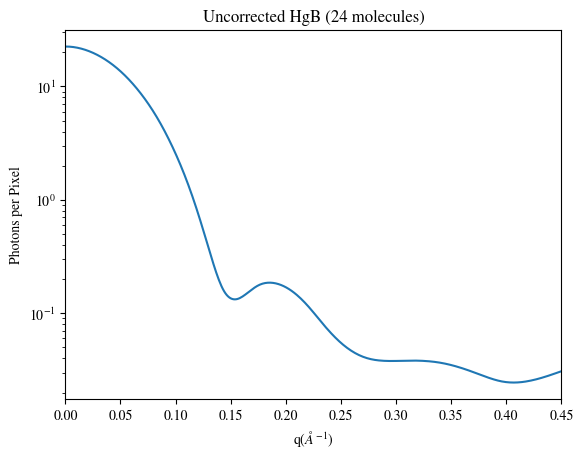

In [32]:
plt.figure()
plt.title(f"Uncorrected HgB ({n_particles} molecules)")
plt.semilogy(q_bins*1e-10, I / geom.n_pixels)
plt.ylabel("Photons per Pixel")
plt.xlabel("q($\AA^{-1}$)")
plt.xlim([0, 0.45])
plt.show()

In [33]:
I *= n_particles * f2p

/lscratch/aansari2/tmp/ipykernel_2064985/1704162361.py:3: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(q_bins*1e-10, I / weights)


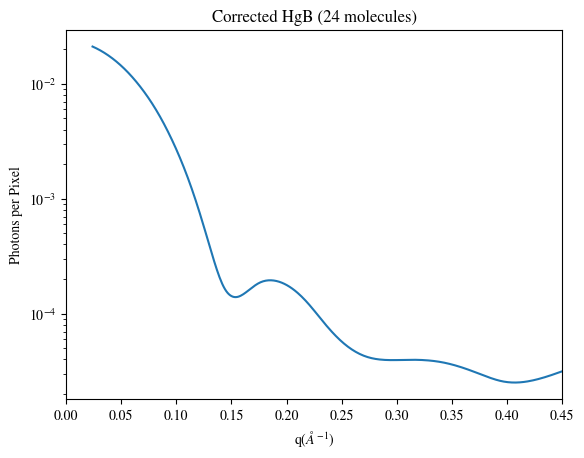

In [34]:
plt.figure()
plt.title(f"Corrected HgB ({n_particles} molecules)")
plt.semilogy(q_bins*1e-10, I / weights)
plt.ylabel("Photons per Pixel")
plt.xlabel("q($\AA^{-1}$)")
plt.xlim([0, 0.45])
plt.show()

/lscratch/aansari2/tmp/ipykernel_2064985/1976030254.py:5: RuntimeWarning: invalid value encountered in divide
  ax1.semilogy(q_bins*1e-10, I / weights, color="tab:red")
/lscratch/aansari2/tmp/ipykernel_2064985/1976030254.py:7: RuntimeWarning: invalid value encountered in divide
  ax1.plot(q_bins*1e-10, I_h20 / weights, color="tab:blue")


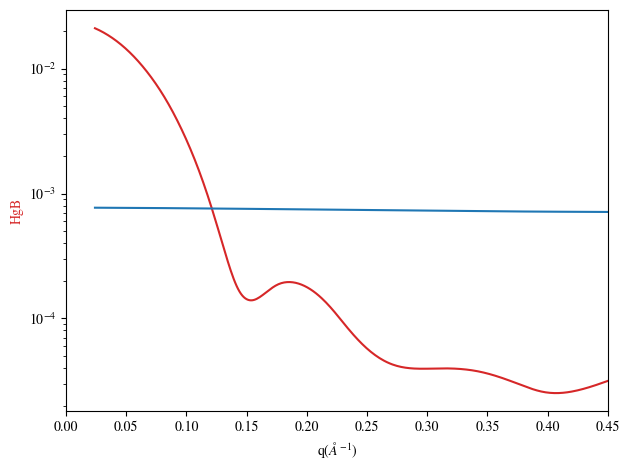

In [35]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("q($\AA^{-1}$)")
ax1.set_ylabel("HgB", color="tab:red")
ax1.semilogy(q_bins*1e-10, I / weights, color="tab:red")
#ax2.set_ylabel("H$_2$O", color="tab:blue")
ax1.plot(q_bins*1e-10, I_h20 / weights, color="tab:blue")

plt.xlim([0, 0.45])
fig.tight_layout()
plt.show()

/lscratch/aansari2/tmp/ipykernel_2064985/659684865.py:1: RuntimeWarning: invalid value encountered in divide
  plt.stackplot(q_bins*1e-10, I_h20 / weights , I / weights)


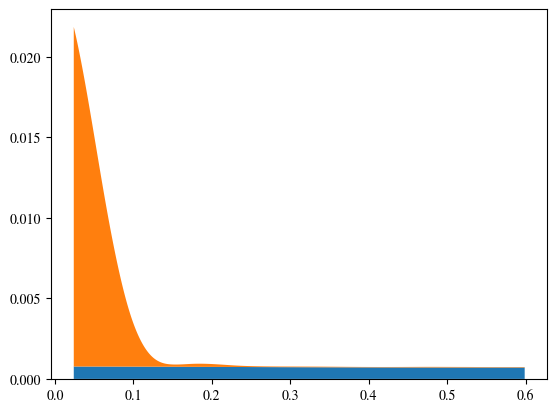

In [36]:
plt.stackplot(q_bins*1e-10, I_h20 / weights , I / weights)
